In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
time_step = []
sunspots = []

with open('E:/Datasets/Sunspot/Sunspots.csv') as csvfile:
    
    reader = csv.reader(csvfile , delimiter = ',')
    next(reader)
    
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

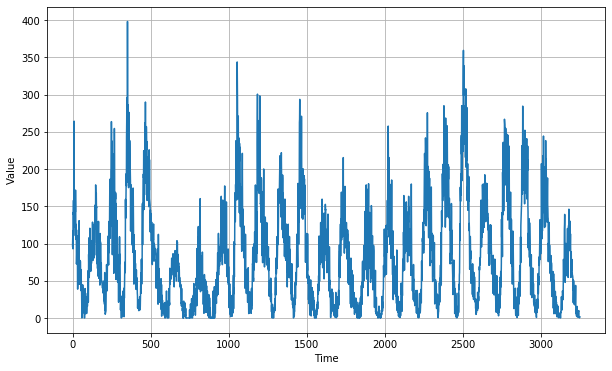

In [4]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10 , 6))
plot_series(time , series)

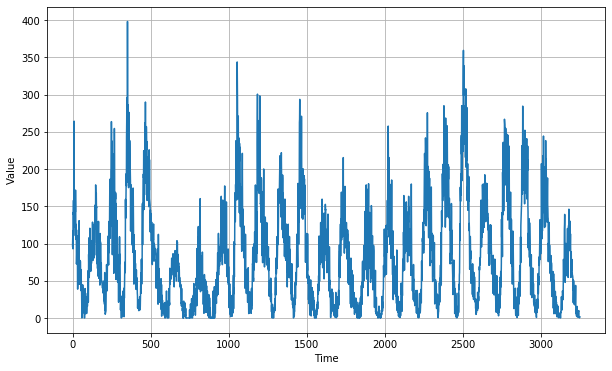

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10 , 6))
plot_series(time , series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    series = tf.expand_dims(series , axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train , window_size , batch_size , shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [10]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters = 32 , kernel_size = 5,
                                                          strides = 1 , padding = 'causal',
                                                          activation = 'relu',
                                                          input_shape = [None , 1]),
        tf.keras.layers.LSTM(64 , return_sequences = True),
        tf.keras.layers.LSTM(64 , return_sequences = True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
])

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8 , momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set , epochs = 100)

Epoch 1/100
12/12 [==============================] - 11s 894ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 2s 129ms/step - loss: 77.9827 - mae: 78.6352
Epoch 3/100
12/12 [==============================] - 2s 133ms/step - loss: 75.5474 - mae: 76.2596
Epoch 4/100
12/12 [==============================] - 2s 127ms/step - loss: 73.1317 - mae: 73.6720
Epoch 5/100
12/12 [==============================] - 2s 128ms/step - loss: 70.3079 - mae: 71.0687
Epoch 6/100
12/12 [==============================] - 1s 122ms/step - loss: 67.7847 - mae: 68.5587
Epoch 7/100
12/12 [==============================] - 2s 135ms/step - loss: 65.2841 - mae: 66.1808
Epoch 8/100
12/12 [==============================] - 2s 131ms/step - loss: 63.5672 - mae: 63.9930
Epoch 9/100
12/12 [==============================] - 2s 129ms/step - loss: 61.0979 - mae: 61.9984
Epoch 10/100
12/12 [==============================] - 2s 128ms/step - loss: 59.4434 - mae: 60.1983
Epoch 11/100
12/12

12/12 [==============================] - 2s 128ms/step - loss: 37.3431 - mae: 37.8940
Epoch 84/100
12/12 [==============================] - 2s 128ms/step - loss: 37.0932 - mae: 37.7911
Epoch 85/100
12/12 [==============================] - 2s 126ms/step - loss: 37.0887 - mae: 37.6838
Epoch 86/100
12/12 [==============================] - 2s 128ms/step - loss: 36.9386 - mae: 37.5810
Epoch 87/100
12/12 [==============================] - 2s 128ms/step - loss: 36.8169 - mae: 37.4736
Epoch 88/100
12/12 [==============================] - 2s 128ms/step - loss: 36.7995 - mae: 37.3699
Epoch 89/100
12/12 [==============================] - 2s 126ms/step - loss: 36.5985 - mae: 37.2617
Epoch 90/100
12/12 [==============================] - 2s 129ms/step - loss: 36.5463 - mae: 37.1588
Epoch 91/100
12/12 [==============================] - 2s 126ms/step - loss: 36.5278 - mae: 37.0549
Epoch 92/100
12/12 [==============================] - 2s 125ms/step - loss: 36.3455 - mae: 36.9536
Epoch 93/100
12/12 [===

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

KeyError: 'lr'

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 252ms/step - loss: 37.8896 - mae: 38.605940.0812 
Epoch 2/500
30/30 [==============================] - 2s 64ms/step - loss: 24.1486 - mae: 24.6131
Epoch 3/500
30/30 [==============================] - 2s 73ms/step - loss: 22.0198 - mae: 22.5111
Epoch 4/500
30/30 [==============================] - 2s 80ms/step - loss: 19.8407 - mae: 20.3425: 1s - loss: 19.8465 - 
Epoch 5/500
30/30 [==============================] - 2s 67ms/step - loss: 19.5149 - mae: 20.0174
Epoch 6/500
30/30 [==============================] - 2s 77ms/step - loss: 19.1203 - mae: 19.6118: 3s - loss: 18.7
Epoch 7/500
30/30 [==============================] - 3s 87ms/step - loss: 18.9760 - mae: 19.4574
Epoch 8/500
30/30 [==============================] - 2s 61ms/step - loss: 18.4022 - mae: 18.8905
Epoch 9/500
30/30 [==============================] - 2s 57ms/step - loss: 18.1999 - mae: 18.7029
Epoch 10/500
30/30 [==============================] - 2s 57ms/step - loss: 18.

30/30 [==============================] - 2s 57ms/step - loss: 16.3637 - mae: 16.8697
Epoch 84/500
30/30 [==============================] - 2s 57ms/step - loss: 16.4239 - mae: 16.9212
Epoch 85/500
30/30 [==============================] - 2s 58ms/step - loss: 16.4718 - mae: 16.9653
Epoch 86/500
30/30 [==============================] - 2s 58ms/step - loss: 16.3674 - mae: 16.8646
Epoch 87/500
30/30 [==============================] - 2s 59ms/step - loss: 16.5905 - mae: 17.0932: 2s - loss: 15.9783 - ma - ETA: 0s - loss: 16.5889 - mae: 17.078 - ETA: 0s - loss: 16.5848 - mae: 17.07
Epoch 88/500
30/30 [==============================] - 2s 59ms/step - loss: 16.4415 - mae: 16.9577
Epoch 89/500
30/30 [==============================] - 2s 59ms/step - loss: 16.4427 - mae: 16.9299
Epoch 90/500
30/30 [==============================] - 2s 57ms/step - loss: 16.5785 - mae: 17.0575
Epoch 91/500
30/30 [==============================] - 2s 57ms/step - loss: 16.3417 - mae: 16.8358
Epoch 92/500
30/30 [=======

30/30 [==============================] - 2s 59ms/step - loss: 15.8728 - mae: 16.3745
Epoch 165/500
30/30 [==============================] - 2s 59ms/step - loss: 15.8719 - mae: 16.3770
Epoch 166/500
30/30 [==============================] - 2s 59ms/step - loss: 15.9787 - mae: 16.4564
Epoch 167/500
30/30 [==============================] - 2s 63ms/step - loss: 15.7969 - mae: 16.2881
Epoch 168/500
30/30 [==============================] - 2s 69ms/step - loss: 15.7868 - mae: 16.2892
Epoch 169/500
30/30 [==============================] - 3s 106ms/step - loss: 15.8514 - mae: 16.3478
Epoch 170/500
30/30 [==============================] - 2s 60ms/step - loss: 15.7931 - mae: 16.2756
Epoch 171/500
30/30 [==============================] - 2s 59ms/step - loss: 15.8089 - mae: 16.3032
Epoch 172/500
30/30 [==============================] - 2s 60ms/step - loss: 15.7366 - mae: 16.2306
Epoch 173/500
30/30 [==============================] - 2s 58ms/step - loss: 15.8512 - mae: 16.3306
Epoch 174/500
30/30 [==

30/30 [==============================] - 2s 59ms/step - loss: 15.4683 - mae: 15.9341
Epoch 247/500
30/30 [==============================] - 2s 61ms/step - loss: 15.4202 - mae: 15.8782
Epoch 248/500
30/30 [==============================] - 2s 65ms/step - loss: 15.3172 - mae: 15.8142
Epoch 249/500
30/30 [==============================] - 2s 65ms/step - loss: 15.3373 - mae: 15.8405
Epoch 250/500
30/30 [==============================] - 2s 64ms/step - loss: 15.2878 - mae: 15.7733
Epoch 251/500
30/30 [==============================] - 2s 63ms/step - loss: 15.3651 - mae: 15.8323
Epoch 252/500
30/30 [==============================] - 2s 58ms/step - loss: 15.4028 - mae: 15.8813
Epoch 253/500
30/30 [==============================] - 2s 59ms/step - loss: 15.3194 - mae: 15.8057
Epoch 254/500
30/30 [==============================] - 3s 105ms/step - loss: 15.3416 - mae: 15.8334
Epoch 255/500
30/30 [==============================] - 2s 57ms/step - loss: 15.3455 - mae: 15.8052
Epoch 256/500
30/30 [==

30/30 [==============================] - 2s 58ms/step - loss: 15.0538 - mae: 15.5343
Epoch 328/500
30/30 [==============================] - 2s 58ms/step - loss: 14.8956 - mae: 15.3791
Epoch 329/500
30/30 [==============================] - 2s 62ms/step - loss: 14.9871 - mae: 15.4843
Epoch 330/500
30/30 [==============================] - 3s 104ms/step - loss: 14.9760 - mae: 15.4578
Epoch 331/500
30/30 [==============================] - 2s 58ms/step - loss: 14.9182 - mae: 15.3962
Epoch 332/500
30/30 [==============================] - 2s 57ms/step - loss: 14.8502 - mae: 15.3288
Epoch 333/500
30/30 [==============================] - 2s 59ms/step - loss: 14.9527 - mae: 15.4348
Epoch 334/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8826 - mae: 15.3811
Epoch 335/500
30/30 [==============================] - 2s 58ms/step - loss: 14.9654 - mae: 15.4409
Epoch 336/500
30/30 [==============================] - 2s 80ms/step - loss: 14.9414 - mae: 15.4286
Epoch 337/500
30/30 [==

30/30 [==============================] - 2s 61ms/step - loss: 14.4832 - mae: 14.9748
Epoch 410/500
30/30 [==============================] - 2s 67ms/step - loss: 14.5040 - mae: 14.9923
Epoch 411/500
30/30 [==============================] - 3s 106ms/step - loss: 14.5852 - mae: 15.0740
Epoch 412/500
30/30 [==============================] - 2s 61ms/step - loss: 14.5835 - mae: 15.0684
Epoch 413/500
30/30 [==============================] - 2s 61ms/step - loss: 14.5394 - mae: 15.0289
Epoch 414/500
30/30 [==============================] - 3s 105ms/step - loss: 14.5941 - mae: 15.0803
Epoch 415/500
30/30 [==============================] - 2s 57ms/step - loss: 14.6381 - mae: 15.1256
Epoch 416/500
30/30 [==============================] - 2s 59ms/step - loss: 14.5703 - mae: 15.0664
Epoch 417/500
30/30 [==============================] - 2s 60ms/step - loss: 14.5382 - mae: 15.0151
Epoch 418/500
30/30 [==============================] - 3s 106ms/step - loss: 14.5118 - mae: 14.9987
Epoch 419/500
30/30 [

30/30 [==============================] - 2s 69ms/step - loss: 14.1601 - mae: 14.6534
Epoch 492/500
30/30 [==============================] - 2s 76ms/step - loss: 14.1654 - mae: 14.6464: 2s - loss: 13.8
Epoch 493/500
30/30 [==============================] - 3s 106ms/step - loss: 14.1913 - mae: 14.6863
Epoch 494/500
30/30 [==============================] - 3s 111ms/step - loss: 14.2201 - mae: 14.6950
Epoch 495/500
30/30 [==============================] - 2s 70ms/step - loss: 14.2111 - mae: 14.6909
Epoch 496/500
30/30 [==============================] - 3s 101ms/step - loss: 14.1708 - mae: 14.6662
Epoch 497/500
30/30 [==============================] - 2s 69ms/step - loss: 14.1860 - mae: 14.6904
Epoch 498/500
30/30 [==============================] - 2s 71ms/step - loss: 14.1939 - mae: 14.6833
Epoch 499/500
30/30 [==============================] - 4s 117ms/step - loss: 14.1298 - mae: 14.6059
Epoch 500/500
30/30 [==============================] - 3s 109ms/step - loss: 14.3917 - mae: 14.8808


In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

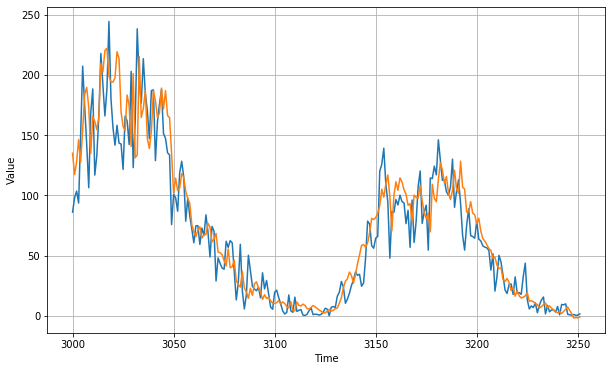

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)